In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [4]:
# Scrape Wikipedia for S&P 500 tickers
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Pretend to be a common browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Fetch the page *with the headers*
response = requests.get(url, headers=headers)

# --- DIAGNOSTIC CHECK ---
# Check if the request was successful (should be 200)
print(f"Request Status Code: {response.status_code}")

soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', {'id': 'constituents'})
if table:
    print("\nSuccess! Found the table with id='constituents'.")
    ticker_list = []
    
    # Get all rows from the table body, skip the header row [1:]
    for row in table.find('tbody').find_all('tr')[1:]: 
        
        # Get all data cells ('td') in the row
        cols = row.find_all('td')
        
        if cols:
            # The ticker is the text in the very first cell (index 0)
            ticker = cols[0].text.strip()
            ticker_list.append(ticker)

    print(f"Total tickers: {len(ticker_list)}")
    # Change "." to "-". This is because the Wikipedia list uses "BRK.B" but yfinance uses "BRK-B"
    ticker_list = [ticker.replace('.', '-') for ticker in ticker_list]
    print(ticker_list)
else:
    print("\nError: Could not find table with id='constituents' even with headers.")
    print("This is strange, the page structure may have changed.")


Request Status Code: 200

Success! Found the table with id='constituents'.
Total tickers: 503
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APP', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK-B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'XYZ', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CPT', 'CPB', 'COF', 'CAH', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'COIN', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTV

In [5]:
def get_sector_map(tickers):
    """
    Fetches sector information for a list of tickers.
    Note: Fetching info one-by-one can be slow.
    """
    sector_map = {}
    print("Fetching sector data (this may take a moment)...")
    for i, ticker in enumerate(tickers, 1):
        try:
            # In a production environment, cache this data
            info = yf.Ticker(ticker).info
            sector_map[ticker] = info.get('sector', 'Unknown')
            if i % 50 == 0:
                print(f"Processed {i}/{len(tickers)} tickers...")
        except Exception as e:
            print(f"Could not fetch sector for {ticker}: {e}")
            sector_map[ticker] = 'Unknown'
    return sector_map

def calculate_momentum_factor(tickers, lookback_years=5):
    # 1. FETCH DATA
    print("Downloading price history...")
    print(f"Attempting to download {len(tickers)} tickers...")
    
    try:
        data = yf.download(
            tickers, 
            period=f"{lookback_years}y", 
            interval="1mo", 
            progress=True,
            auto_adjust=True,
            threads=True
        )
        
        # When auto_adjust=True, yfinance returns adjusted prices directly
        # For multiple tickers, columns are multi-level: (Price Type, Ticker)
        # We need to extract just the Close prices
        if isinstance(data.columns, pd.MultiIndex):
            # Multi-ticker case: select 'Close' from the multi-level columns
            if 'Close' in data.columns.get_level_values(0):
                data = data['Close']
            else:
                print("Available columns:", data.columns.get_level_values(0).unique().tolist())
                print("Error: Could not find 'Close' prices in data")
                return None, None, None
        else:
            # Single ticker or already the right format
            if 'Close' in data.columns:
                data = data['Close']
            
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None, None, None
    
    # Drop columns with insufficient history (less than 12 months)
    # We require > 12 non-NaN values
    data = data.dropna(axis=1, thresh=12)
    valid_tickers = data.columns.tolist()
    
    if len(valid_tickers) == 0:
        print("ERROR: No valid tickers with sufficient data!")
        print("This may be due to network issues or yfinance rate limiting.")
        print("Try running the cell again or reduce the number of tickers.")
        return None, None, None
    
    # 2. CALCULATE RAW MOMENTUM
    # Formula: P(t-2) / P(t-12) - 1
    # logic: shift(2) moves the price from 2 months ago to current row
    mom_raw = data.shift(2) / data.shift(12) - 1
    
    # Drop the first 12 months as they will be NaN due to the shift
    mom_raw = mom_raw.dropna(how='all')

    # 3. PREPARE FOR CROSS-SECTIONAL STANDARDIZATION
    # Convert from Wide (Tickers as columns) to Long (Date/Ticker rows)
    df_long = mom_raw.stack().reset_index()
    df_long.columns = ['Date', 'Ticker', 'Raw_Momentum']
    
    # Map Sectors
    sector_map = get_sector_map(valid_tickers)
    df_long['Sector'] = df_long['Ticker'].map(sector_map)

    # 4. WINSORIZATION (Cross-sectional per Date)
    # We clip outliers at the 5th and 95th percentiles for each month
    def winsorize_group(group):
        lower = group.quantile(0.05)
        upper = group.quantile(0.95)
        return group.clip(lower, upper)

    df_long['Mom_Winsorized'] = df_long.groupby('Date')['Raw_Momentum'] \
                                       .transform(winsorize_group)

    # 5. SECTOR Z-SCORES
    # Calculate Z-Score per Date and Sector
    # Formula: (x - mean) / std
    def calc_zscore(group):
        if len(group) < 2: 
            return 0.0 # Neutral score if not enough peers in sector
        sigma = group.std()
        if sigma == 0:
            return 0.0
        return (group - group.mean()) / sigma

    df_long['Z_Momentum'] = df_long.groupby(['Date', 'Sector'])['Mom_Winsorized'] \
                                   .transform(calc_zscore)
    
    # 6. ADD QUINTILES
    # Group by date and assign quintiles (1 = lowest momentum, 5 = highest momentum)
    df_long['Momentum_Quintile'] = df_long.groupby('Date')['Z_Momentum'].transform(
        lambda x: pd.qcut(x, q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
    )
    
    # 7. CALCULATE FORWARD RETURNS
    # Convert price_data to long format
    price_long = data.stack().reset_index()
    price_long.columns = ['Date', 'Ticker', 'Price']
    price_long = price_long.sort_values(['Ticker', 'Date'])
    
    # Calculate forward return: P(t+1)/P(t) - 1
    price_long['Forward_Return'] = price_long.groupby('Ticker')['Price'].transform(
        lambda x: x.shift(-1) / x - 1
    )
    
    # Merge forward returns with detailed_df
    df_long = df_long.merge(
        price_long[['Date', 'Ticker', 'Forward_Return']],
        on=['Date', 'Ticker'],
        how='left'
    )
    
    # Pivot back to wide format for easy viewing/trading matrix
    final_factor = df_long.pivot(index='Date', columns='Ticker', values='Z_Momentum')
    
    return final_factor, df_long, data

# --- EXECUTION ---

# Run calculation
z_score_matrix, detailed_df, price_data = calculate_momentum_factor(ticker_list)

# Check if calculation was successful
if z_score_matrix is not None and not z_score_matrix.empty:
    # Display quintile distribution
    print("MOMENTUM QUINTILE DISTRIBUTION")
    print("\nQuintile Distribution:")
    print(detailed_df['Momentum_Quintile'].value_counts().sort_index())
    print(f"\nSample of data with quintiles:")
    print(detailed_df[['Date', 'Ticker', 'Z_Momentum', 'Momentum_Quintile']].head(20))
    
    # Calculate backtest statistics
    print("MOMENTUM STRATEGY BACKTEST - Monthly Rebalancing")
    
    quintile_stats = detailed_df.groupby('Momentum_Quintile')['Forward_Return'].agg([
        ('Mean_Monthly_Return', 'mean'),
        ('Median_Monthly_Return', 'median'),
        ('Std_Dev', 'std'),
        ('Count', 'count')
    ])
    
    # Convert to percentage
    quintile_stats['Mean_Monthly_Return'] = quintile_stats['Mean_Monthly_Return'] * 100
    quintile_stats['Median_Monthly_Return'] = quintile_stats['Median_Monthly_Return'] * 100
    quintile_stats['Std_Dev'] = quintile_stats['Std_Dev'] * 100
    
    print("\nAverage Returns by Momentum Quintile (%):")
    print(quintile_stats)
    
    # Calculate spread (Q5 - Q1)
    if 5 in quintile_stats.index and 1 in quintile_stats.index:
        spread = quintile_stats.loc[5, 'Mean_Monthly_Return'] - quintile_stats.loc[1, 'Mean_Monthly_Return']
        print(f"\nMomentum Spread (Q5 - Q1): {spread:.2f}% per month")
        print(f"Annualized Spread: {spread * 12:.2f}%")
    
    # Output the most recent Momentum Z-Scores
    print("Most Recent Momentum Z-Scores (Top 10):")
    latest_date = z_score_matrix.index[-1]
    print(z_score_matrix.loc[latest_date].sort_values(ascending=False).head(10))
else:
    print("\nCalculation failed. Please check the errors above and try again.")


Attempting to download 503 tickers...


[*********************100%***********************]  503 of 503 completed



Fetching sector data (this may take a moment)...
Processed 50/501 tickers...
Processed 50/501 tickers...
Processed 100/501 tickers...
Processed 100/501 tickers...
Processed 150/501 tickers...
Processed 150/501 tickers...
Processed 200/501 tickers...
Processed 200/501 tickers...
Processed 250/501 tickers...
Processed 250/501 tickers...
Processed 300/501 tickers...
Processed 300/501 tickers...
Processed 350/501 tickers...
Processed 350/501 tickers...
Processed 400/501 tickers...
Processed 400/501 tickers...
Processed 450/501 tickers...
Processed 450/501 tickers...
Processed 500/501 tickers...
Processed 500/501 tickers...
MOMENTUM QUINTILE DISTRIBUTION

Quintile Distribution:
Momentum_Quintile
1    4797
2    4756
3    4756
4    4762
5    4770
Name: count, dtype: int64

Sample of data with quintiles:
         Date Ticker  Z_Momentum Momentum_Quintile
0  2021-12-01      A    0.476937                 4
1  2021-12-01   AAPL   -0.522008                 2
2  2021-12-01   ABBV   -0.553358       

C:\Users\ryant\AppData\Local\Temp\ipykernel_24424\487562654.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_stats = detailed_df.groupby('Momentum_Quintile')['Forward_Return'].agg([


In [6]:
def calculate_defensive_factor(tickers, sector_map, lookback_years=5, min_daily_obs=40):
    """
    Calculate Low Volatility (Defensive) Factor
    
    Methodology:
    1. Download daily price data
    2. Calculate 60-day realized volatility using log returns
    3. Annualize volatility: sqrt(252) * std(log returns over 60 days)
    4. Invert volatility (lower vol = better): x_low = -sigma
    5. Winsorize across stocks
    6. Calculate sector-neutral Z-scores
    
    Parameters:
    - tickers: List of stock tickers
    - sector_map: Dictionary mapping tickers to sectors (to avoid re-fetching)
    - lookback_years: Years of historical data to fetch
    - min_daily_obs: Minimum daily observations required (default 40 out of 60)
    
    Returns:
    - z_score_matrix: Wide format (Date x Ticker) of defensive Z-scores
    - detailed_df: Long format with all intermediate calculations
    """
    
    
    # 1. FETCH DAILY DATA
    print(f"\nDownloading daily price data for {len(tickers)} tickers...")
    
    try:
        data = yf.download(
            tickers,
            period=f"{lookback_years}y",
            interval="1d",
            progress=True,
            auto_adjust=True,
            threads=True
        )
        
        # Extract Close prices
        if isinstance(data.columns, pd.MultiIndex):
            if 'Close' in data.columns.get_level_values(0):
                prices = data['Close']
            else:
                print("Error: Could not find 'Close' prices")
                return None, None
        else:
            if 'Close' in data.columns:
                prices = data['Close']
            else:
                prices = data
                
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None, None
    
    print(f"Data shape: {prices.shape}")
    
    # 2. CALCULATE DAILY LOG RETURNS
    print("\nCalculating daily log returns...")
    log_returns = np.log(prices / prices.shift(1))
    
    # 3. CALCULATE 60-DAY ROLLING VOLATILITY (ANNUALIZED)
    print("Calculating 60-day rolling realized volatility...")
    window = 60
    
    # Rolling standard deviation of log returns
    rolling_vol = log_returns.rolling(window=window, min_periods=min_daily_obs).std()
    
    # Annualize: multiply by sqrt(252 trading days)
    annualized_vol = rolling_vol * np.sqrt(252)
    
    # 4. RESAMPLE TO MONTHLY (END OF MONTH)
    print("Resampling to monthly frequency...")
    monthly_vol = annualized_vol.resample('M').last()
    
    # Drop tickers with insufficient data
    monthly_vol = monthly_vol.dropna(axis=1, thresh=12)
    valid_tickers = monthly_vol.columns.tolist()
    
    print(f"Valid tickers with sufficient data: {len(valid_tickers)}")
    
    if len(valid_tickers) == 0:
        print("ERROR: No valid tickers with sufficient data!")
        return None, None
    
    # 5. INVERT VOLATILITY (LOWER VOL IS BETTER)
    # Define x_low = -sigma
    low_vol_signal = -monthly_vol
    
    # Drop rows with all NaN
    low_vol_signal = low_vol_signal.dropna(how='all')
    
    # 6. PREPARE FOR CROSS-SECTIONAL STANDARDIZATION
    # Convert to long format
    df_long = low_vol_signal.stack().reset_index()
    df_long.columns = ['Date', 'Ticker', 'Low_Vol_Raw']
    
    # Add original volatility for reference
    vol_long = monthly_vol.stack().reset_index()
    vol_long.columns = ['Date', 'Ticker', 'Realized_Vol']
    df_long = df_long.merge(vol_long, on=['Date', 'Ticker'], how='left')
    
    # Map Sectors (reuse sector map from momentum calculation)
    print("\nMapping sectors from existing sector map...")
    df_long['Sector'] = df_long['Ticker'].map(sector_map)
    
    # 7. WINSORIZATION (Cross-sectional per Date)
    print("Applying winsorization...")
    def winsorize_group(group):
        lower = group.quantile(0.05)
        upper = group.quantile(0.95)
        return group.clip(lower, upper)
    
    df_long['Low_Vol_Winsorized'] = df_long.groupby('Date')['Low_Vol_Raw'] \
                                           .transform(winsorize_group)
    
    # 8. SECTOR Z-SCORES
    print("Calculating sector-neutral Z-scores...")
    def calc_zscore(group):
        if len(group) < 2:
            return 0.0
        sigma = group.std()
        if sigma == 0:
            return 0.0
        return (group - group.mean()) / sigma
    
    df_long['Z_LowVol'] = df_long.groupby(['Date', 'Sector'])['Low_Vol_Winsorized'] \
                                 .transform(calc_zscore)
    
    # Pivot to wide format
    final_factor = df_long.pivot(index='Date', columns='Ticker', values='Z_LowVol')
    
    return final_factor, df_long

# --- EXECUTION ---
# Extract sector map from detailed_df to reuse it
sector_map = detailed_df[['Ticker', 'Sector']].drop_duplicates().set_index('Ticker')['Sector'].to_dict()

print("\nRunning defensive factor calculation...")
lowvol_matrix, defensive_df = calculate_defensive_factor(ticker_list, sector_map)

# Check if calculation was successful
if lowvol_matrix is not None and not lowvol_matrix.empty:
    print("\n" + "="*70)
    print("CALCULATION SUCCESSFUL")
    print("="*70)
    print(f"\nData shape: {defensive_df.shape}")
    print(f"Date range: {defensive_df['Date'].min()} to {defensive_df['Date'].max()}")
    print(f"\nMost Recent Low Volatility Z-Scores (Top 10):")
    latest_date = lowvol_matrix.index[-1]
    print(lowvol_matrix.loc[latest_date].sort_values(ascending=False).head(10))
else:
    print("\nCalculation failed. Please check the errors above and try again.")


Running defensive factor calculation...



[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['ES']: Timeout('Failed to perform, curl: (28) Operation timed out after 10003 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['CME']: Timeout('Failed to perform, curl: (28) Connection timed out after 10014 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['ES']: Timeout('Failed to perform, curl: (28) Operation timed out after 10003 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['CME']: Timeout('Failed to perform, curl: (28) Connection timed out after 10014 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Data shape: (1256, 503)

Calculating daily log returns...
Calculating 60-day rolling realized volatility...
Resampling to monthly frequency...
Valid tickers with sufficient data: 499

Mapping sectors from existing sector map...
Applying winsorization...


C:\Users\ryant\AppData\Local\Temp\ipykernel_24424\3980232548.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_vol = annualized_vol.resample('M').last()


Calculating sector-neutral Z-scores...

CALCULATION SUCCESSFUL

Data shape: (29235, 7)
Date range: 2021-01-31 00:00:00 to 2025-11-30 00:00:00

Most Recent Low Volatility Z-Scores (Top 10):
Ticker
DAY     1.747085
JNJ     1.656692
BR      1.627557
TJX     1.550283
MCD     1.549949
MSFT    1.491725
LIN     1.419877
ADP     1.402545
PG      1.384072
K       1.384072
Name: 2025-11-30 00:00:00, dtype: float64

CALCULATION SUCCESSFUL

Data shape: (29235, 7)
Date range: 2021-01-31 00:00:00 to 2025-11-30 00:00:00

Most Recent Low Volatility Z-Scores (Top 10):
Ticker
DAY     1.747085
JNJ     1.656692
BR      1.627557
TJX     1.550283
MCD     1.549949
MSFT    1.491725
LIN     1.419877
ADP     1.402545
PG      1.384072
K       1.384072
Name: 2025-11-30 00:00:00, dtype: float64


In [7]:
# Add defensive quintiles based on Z_LowVol scores
defensive_df['Defensive_Quintile'] = defensive_df.groupby('Date')['Z_LowVol'].transform(
    lambda x: pd.qcut(x, q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
)

print("="*70)
print("DEFENSIVE FACTOR - QUINTILE DISTRIBUTION")
print("="*70)
print("\nQuintile Distribution:")
print(defensive_df['Defensive_Quintile'].value_counts().sort_index())
print(f"\nSample of data with quintiles:")
print(defensive_df[['Date', 'Ticker', 'Realized_Vol', 'Z_LowVol', 'Defensive_Quintile']].head(20))

DEFENSIVE FACTOR - QUINTILE DISTRIBUTION

Quintile Distribution:
Defensive_Quintile
1    5872
2    5838
3    5819
4    5860
5    5846
Name: count, dtype: int64

Sample of data with quintiles:
         Date Ticker  Realized_Vol  Z_LowVol Defensive_Quintile
0  2021-01-31      A      0.212367  0.840824                  4
1  2021-01-31   AAPL      0.319223 -0.123850                  2
2  2021-01-31   ABBV      0.231351  0.540773                  4
3  2021-01-31    ABT      0.194546  1.122490                  5
4  2021-01-31   ACGL      0.318919 -0.448051                  2
5  2021-01-31    ACN      0.245905  0.712264                  4
6  2021-01-31   ADBE      0.241050  0.767627                  4
7  2021-01-31    ADI      0.240190  0.777441                  4
8  2021-01-31    ADM      0.259393 -0.337141                  2
9  2021-01-31    ADP      0.183162  1.407237                  5
10 2021-01-31   ADSK      0.316312 -0.090658                  3
11 2021-01-31    AEE      0.209598  0.64

In [8]:
# Calculate forward returns for defensive factor backtesting
print("="*70)
print("DEFENSIVE FACTOR BACKTEST - Monthly Rebalancing")
print("="*70)

# Sort by Ticker and Date to ensure proper ordering
defensive_df = defensive_df.sort_values(['Ticker', 'Date'])

# Normalize dates to month-start for both dataframes to enable merging
print("\nAligning dates and merging forward returns from momentum calculation...")

# Convert defensive_df dates to period (month) then back to start of month
defensive_df['Date_Month'] = pd.to_datetime(defensive_df['Date']).dt.to_period('M').dt.to_timestamp()

# Extract returns from detailed_df with month-start dates (these are now proper 1-month returns)
returns_from_momentum = detailed_df[['Date', 'Ticker', 'Forward_Return']].copy()

# Merge on the normalized month date
defensive_df = defensive_df.merge(
    returns_from_momentum, 
    left_on=['Date_Month', 'Ticker'],
    right_on=['Date', 'Ticker'],
    how='left',
    suffixes=('', '_mom')
)

# Drop the temporary columns and keep original Date from defensive_df
defensive_df = defensive_df.drop(columns=['Date_mom', 'Date_Month'])

# Calculate quintile statistics
print("\nCalculating quintile performance statistics...")

quintile_stats = defensive_df.groupby('Defensive_Quintile')['Forward_Return'].agg([
    ('Mean_Monthly_Return', 'mean'),
    ('Median_Monthly_Return', 'median'),
    ('Std_Dev', 'std'),
    ('Count', 'count')
])

# Convert to percentage
quintile_stats['Mean_Monthly_Return'] = quintile_stats['Mean_Monthly_Return'] * 100
quintile_stats['Median_Monthly_Return'] = quintile_stats['Median_Monthly_Return'] * 100
quintile_stats['Std_Dev'] = quintile_stats['Std_Dev'] * 100

print("\n" + "="*70)
print("Average Returns by Defensive Quintile (%):")
print("Quintile 5 = Lowest Volatility (Most Defensive)")
print("Quintile 1 = Highest Volatility (Least Defensive)")
print("="*70)
print(quintile_stats)

# Calculate spread (Q5 - Q1)
# For defensive, we expect Q5 (low vol) to have better risk-adjusted returns
if 5 in quintile_stats.index and 1 in quintile_stats.index:
    spread = quintile_stats.loc[5, 'Mean_Monthly_Return'] - quintile_stats.loc[1, 'Mean_Monthly_Return']
    print(f"\nDefensive Spread (Low Vol - High Vol): {spread:.2f}% per month")
    print(f"Annualized Spread: {spread * 12:.2f}%")
    
    # Calculate Sharpe ratio for each quintile
    print("\nSharpe Ratios by Quintile (assuming 0% risk-free rate):")
    for q in range(1, 6):
        if q in quintile_stats.index:
            mean_ret = quintile_stats.loc[q, 'Mean_Monthly_Return']
            std_ret = quintile_stats.loc[q, 'Std_Dev']
            if std_ret > 0:
                sharpe = (mean_ret / std_ret) * np.sqrt(12)  # Annualized
                print(f"Quintile {q}: {sharpe:.3f}")


DEFENSIVE FACTOR BACKTEST - Monthly Rebalancing

Aligning dates and merging forward returns from momentum calculation...

Calculating quintile performance statistics...

Average Returns by Defensive Quintile (%):
Quintile 5 = Lowest Volatility (Most Defensive)
Quintile 1 = Highest Volatility (Least Defensive)
                    Mean_Monthly_Return  Median_Monthly_Return    Std_Dev  \
Defensive_Quintile                                                          
1                              1.516590               0.638540  13.075384   
2                              0.821894               0.609470   9.600069   
3                              0.647536               0.638929   8.222940   
4                              0.672489               0.469715   7.262130   
5                              0.619161               0.575882   6.861399   

                    Count  
Defensive_Quintile         
1                    4626  
2                    4649  
3                    4634  
4        

C:\Users\ryant\AppData\Local\Temp\ipykernel_24424\1394301052.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_stats = defensive_df.groupby('Defensive_Quintile')['Forward_Return'].agg([


In [9]:
# Load quality/value data and prepare for analysis
print("="*70)
print("QUALITY & VALUE FACTORS - DATA PREPARATION")
print("="*70)

# Load the quality/value CSV file
quality_value_df = pd.read_csv('spx_quality_value.csv')

# Replace "/" with "-" in ticker column to match our format
quality_value_df['Ticker'] = quality_value_df['Ticker'].str.replace('/', '-')

# Replace "NM" (Not Meaningful) with 999 for EV/EBIT to place in worst quintile
if 'EV/EBIT' in quality_value_df.columns:
    quality_value_df['EV/EBIT'] = quality_value_df['EV/EBIT'].replace('NM', '999')

print(f"\nLoaded quality/value data:")
print(f"Shape: {quality_value_df.shape}")
print(f"Columns: {quality_value_df.columns.tolist()}")
print(f"\nSample data:")
print(quality_value_df.head())

# Check for required columns
if 'EV/EBIT' in quality_value_df.columns and 'ROIC' in quality_value_df.columns:
    print("\n✓ Found EV/EBIT and ROIC columns")
else:
    print("\n✗ Warning: Could not find expected columns")
    print(f"Available columns: {quality_value_df.columns.tolist()}")


QUALITY & VALUE FACTORS - DATA PREPARATION

Loaded quality/value data:
Shape: (23841, 4)
Columns: ['Date', 'Ticker', 'EV/EBIT', 'ROIC']

Sample data:
        Date Ticker   EV/EBIT     ROIC
0  12/1/2021      A   34.1652  12.3997
1   1/1/2022      A  35.29233  12.3997
2   2/1/2022      A  31.28716  12.4219
3   3/1/2022      A  28.37417  12.4219
4   4/1/2022      A  28.73438  12.4219

✓ Found EV/EBIT and ROIC columns


In [10]:
# Merge quality/value data with detailed_df (momentum data)
print("="*70)
print("MERGING QUALITY/VALUE WITH MOMENTUM DATA")
print("="*70)

# Convert EV/EBIT and ROIC to numeric (handle any non-numeric values)
quality_value_df['EV/EBIT'] = pd.to_numeric(quality_value_df['EV/EBIT'], errors='coerce')
quality_value_df['ROIC'] = pd.to_numeric(quality_value_df['ROIC'], errors='coerce')

print(f"\nConverted to numeric:")
print(f"EV/EBIT type: {quality_value_df['EV/EBIT'].dtype}")
print(f"ROIC type: {quality_value_df['ROIC'].dtype}")

# Check if quality_value_df has a Date column
if 'Date' in quality_value_df.columns:
    print("\nFound Date column in quality_value_df - merging on Ticker and Date")
    # Convert date to datetime for proper matching
    quality_value_df['Date'] = pd.to_datetime(quality_value_df['Date'])
    detailed_df['Date'] = pd.to_datetime(detailed_df['Date'])
    
    # Merge on both Ticker and Date
    merged_df = detailed_df.merge(
        quality_value_df[['Date', 'Ticker', 'EV/EBIT', 'ROIC']], 
        on=['Ticker', 'Date'], 
        how='left'
    )
else:
    print("\nNo Date column in quality_value_df - treating as static data")
    print("Broadcasting quality/value metrics across all dates for each ticker")
    # Merge on Ticker only (broadcasts static values across all dates)
    merged_df = detailed_df.merge(
        quality_value_df[['Ticker', 'EV/EBIT', 'ROIC']], 
        on='Ticker', 
        how='left'
    )

# Now merge with defensive factor data
print("\n" + "="*70)
print("MERGING DEFENSIVE FACTOR DATA")
print("="*70)

# Normalize dates for both dataframes to enable proper merging
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
defensive_df['Date'] = pd.to_datetime(defensive_df['Date'])

# Create normalized month column for matching
merged_df['Date_Month'] = merged_df['Date'].dt.to_period('M').dt.to_timestamp()
defensive_df['Date_Month'] = defensive_df['Date'].dt.to_period('M').dt.to_timestamp()

# Select defensive columns to merge
defensive_cols = ['Date_Month', 'Ticker', 'Realized_Vol', 'Z_LowVol', 'Defensive_Quintile']

# Merge defensive data
merged_df = merged_df.merge(
    defensive_df[defensive_cols],
    left_on=['Date_Month', 'Ticker'],
    right_on=['Date_Month', 'Ticker'],
    how='left',
    suffixes=('', '_def')
)

# Drop the temporary Date_Month column
merged_df = merged_df.drop(columns=['Date_Month'])

# Create Value and Quality quintiles
print("\n" + "="*70)
print("CREATING VALUE AND QUALITY QUINTILES")
print("="*70)

# Value Quintile (EV/EBIT): Lower is better, so invert with -EV/EBIT
merged_df['Value_Quintile'] = merged_df.groupby('Date')['EV/EBIT'].transform(
    lambda x: pd.qcut(-x, q=5, labels=[1, 2, 3, 4, 5], duplicates='drop') if x.notna().sum() >= 5 else np.nan
)

# Quality Quintile (ROIC): Higher is better
merged_df['Quality_Quintile'] = merged_df.groupby('Date')['ROIC'].transform(
    lambda x: pd.qcut(x, q=5, labels=[1, 2, 3, 4, 5], duplicates='drop') if x.notna().sum() >= 5 else np.nan
)

print(f"\nMerged data shape: {merged_df.shape}")
print(f"Columns: {merged_df.columns.tolist()}")

# Check merge success
print(f"\nRows with EV/EBIT data: {merged_df['EV/EBIT'].notna().sum()}")
print(f"Rows with ROIC data: {merged_df['ROIC'].notna().sum()}")
print(f"Rows with Z_LowVol data: {merged_df['Z_LowVol'].notna().sum()}")
print(f"Rows with Defensive_Quintile data: {merged_df['Defensive_Quintile'].notna().sum()}")
print(f"Rows with Value_Quintile data: {merged_df['Value_Quintile'].notna().sum()}")
print(f"Rows with Quality_Quintile data: {merged_df['Quality_Quintile'].notna().sum()}")
print(f"Total rows: {len(merged_df)}")
print(f"\nSample of merged data:")
print(merged_df[['Date', 'Ticker', 'Z_Momentum', 'Momentum_Quintile',
                 'Z_LowVol', 'Defensive_Quintile',
                 'EV/EBIT', 'Value_Quintile',
                 'ROIC', 'Quality_Quintile']].head(20))


MERGING QUALITY/VALUE WITH MOMENTUM DATA

Converted to numeric:
EV/EBIT type: float64
ROIC type: float64

Found Date column in quality_value_df - merging on Ticker and Date

MERGING DEFENSIVE FACTOR DATA

MERGING DEFENSIVE FACTOR DATA

CREATING VALUE AND QUALITY QUINTILES

CREATING VALUE AND QUALITY QUINTILES

Merged data shape: (23841, 15)
Columns: ['Date', 'Ticker', 'Raw_Momentum', 'Sector', 'Mom_Winsorized', 'Z_Momentum', 'Momentum_Quintile', 'Forward_Return', 'EV/EBIT', 'ROIC', 'Realized_Vol', 'Z_LowVol', 'Defensive_Quintile', 'Value_Quintile', 'Quality_Quintile']

Rows with EV/EBIT data: 23841
Rows with ROIC data: 23815
Rows with Z_LowVol data: 23745
Rows with Defensive_Quintile data: 23745
Rows with Value_Quintile data: 23841
Rows with Quality_Quintile data: 23815
Total rows: 23841

Sample of merged data:
         Date Ticker  Z_Momentum Momentum_Quintile  Z_LowVol  \
0  2021-12-01      A    0.476937                 4  0.509052   
1  2021-12-01   AAPL   -0.522008                 

In [11]:
# Backtest Value factor (already created in merged_df)
print("="*70)
print("VALUE FACTOR BACKTEST (EV/EBIT)")
print("="*70)

print("\nValue Quintile Distribution:")
print(merged_df['Value_Quintile'].value_counts().sort_index())
print(f"\nSample data:")
print(merged_df[['Date', 'Ticker', 'EV/EBIT', 'Value_Quintile']].dropna().head(20))

# Calculate forward returns by Value quintile
print("\n" + "="*70)
print("VALUE STRATEGY BACKTEST")
print("="*70)

value_stats = merged_df.groupby('Value_Quintile')['Forward_Return'].agg([
    ('Mean_Monthly_Return', 'mean'),
    ('Median_Monthly_Return', 'median'),
    ('Std_Dev', 'std'),
    ('Count', 'count')
])

# Convert to percentage
value_stats['Mean_Monthly_Return'] = value_stats['Mean_Monthly_Return'] * 100
value_stats['Median_Monthly_Return'] = value_stats['Median_Monthly_Return'] * 100
value_stats['Std_Dev'] = value_stats['Std_Dev'] * 100

print("\nAverage Returns by Value Quintile (%):")
print("Quintile 5 = Lowest EV/EBIT (Best Value)")
print("Quintile 1 = Highest EV/EBIT (Worst Value)")
print("="*70)
print(value_stats)

# Calculate spread
if 5 in value_stats.index and 1 in value_stats.index:
    spread = value_stats.loc[5, 'Mean_Monthly_Return'] - value_stats.loc[1, 'Mean_Monthly_Return']
    print(f"\nValue Spread (Q5 - Q1): {spread:.2f}% per month")
    print(f"Annualized Spread: {spread * 12:.2f}%")


VALUE FACTOR BACKTEST (EV/EBIT)

Value Quintile Distribution:
Value_Quintile
1    4793
2    4760
3    4756
4    4760
5    4772
Name: count, dtype: int64

Sample data:
         Date Ticker   EV/EBIT Value_Quintile
0  2021-12-01      A  34.16520              2
1  2021-12-01   AAPL  24.31677              3
2  2021-12-01   ABBV  13.50405              4
3  2021-12-01    ABT  26.34638              2
4  2021-12-01   ACGL   7.14122              5
5  2021-12-01    ACN  29.30920              2
6  2021-12-01   ADBE  56.43885              1
7  2021-12-01    ADI  48.38231              1
8  2021-12-01    ADM  13.44369              4
9  2021-12-01    ADP  27.88351              2
10 2021-12-01   ADSK  82.59264              1
11 2021-12-01    AEE  23.21377              3
12 2021-12-01    AEP  21.87558              3
13 2021-12-01    AES  14.40739              4
14 2021-12-01    AFL   7.24945              5
15 2021-12-01    AIG   9.26525              5
16 2021-12-01    AIZ   8.67284              5
17 20

C:\Users\ryant\AppData\Local\Temp\ipykernel_24424\2457916920.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_stats = merged_df.groupby('Value_Quintile')['Forward_Return'].agg([


In [12]:
print(value_stats)


                Mean_Monthly_Return  Median_Monthly_Return    Std_Dev  Count
Value_Quintile                                                              
1                          0.659846               0.190101  11.189832   4692
2                          0.502194               0.345489   8.192328   4660
3                          0.809177               0.727093   8.019049   4656
4                          1.092574               0.695909   8.954784   4660
5                          1.199772               0.947590   9.589759   4672


In [13]:
# Backtest Quality factor (already created in merged_df)
print("="*70)
print("QUALITY FACTOR BACKTEST (ROIC)")
print("="*70)

print("\nQuality Quintile Distribution:")
print(merged_df['Quality_Quintile'].value_counts().sort_index())
print(f"\nSample data:")
print(merged_df[['Date', 'Ticker', 'ROIC', 'Quality_Quintile']].dropna().head(20))

# Calculate forward returns by Quality quintile
print("\n" + "="*70)
print("QUALITY STRATEGY BACKTEST")
print("="*70)

quality_stats = merged_df.groupby('Quality_Quintile')['Forward_Return'].agg([
    ('Mean_Monthly_Return', 'mean'),
    ('Median_Monthly_Return', 'median'),
    ('Std_Dev', 'std'),
    ('Count', 'count')
])

# Convert to percentage
quality_stats['Mean_Monthly_Return'] = quality_stats['Mean_Monthly_Return'] * 100
quality_stats['Median_Monthly_Return'] = quality_stats['Median_Monthly_Return'] * 100
quality_stats['Std_Dev'] = quality_stats['Std_Dev'] * 100

print("\nAverage Returns by Quality Quintile (%):")
print("Quintile 5 = Highest ROIC (Best Quality)")
print("Quintile 1 = Lowest ROIC (Worst Quality)")
print("="*70)
print(quality_stats)

# Calculate spread
if 5 in quality_stats.index and 1 in quality_stats.index:
    spread = quality_stats.loc[5, 'Mean_Monthly_Return'] - quality_stats.loc[1, 'Mean_Monthly_Return']
    print(f"\nQuality Spread (Q5 - Q1): {spread:.2f}% per month")
    print(f"Annualized Spread: {spread * 12:.2f}%")


QUALITY FACTOR BACKTEST (ROIC)

Quality Quintile Distribution:
Quality_Quintile
1    4826
2    4711
3    4756
4    4755
5    4767
Name: count, dtype: int64

Sample data:
         Date Ticker     ROIC Quality_Quintile
0  2021-12-01      A  12.3997                4
1  2021-12-01   AAPL  41.4292                5
2  2021-12-01   ABBV  -1.5393                1
3  2021-12-01    ABT   8.1381                3
4  2021-12-01   ACGL  12.4741                4
5  2021-12-01    ACN  16.8952                5
6  2021-12-01   ADBE  32.8605                5
7  2021-12-01    ADI   0.8951                2
8  2021-12-01    ADM   5.8669                3
9  2021-12-01    ADP  13.1215                4
10 2021-12-01   ADSK  40.6088                5
11 2021-12-01    AEE   2.0330                2
12 2021-12-01    AEP   1.5770                2
13 2021-12-01    AES   0.5472                2
14 2021-12-01    AFL   7.8857                3
15 2021-12-01    AIG   4.4638                3
16 2021-12-01    AIZ  15.2589  

C:\Users\ryant\AppData\Local\Temp\ipykernel_24424\3224733538.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quality_stats = merged_df.groupby('Quality_Quintile')['Forward_Return'].agg([


In [14]:
print(quality_stats)


                  Mean_Monthly_Return  Median_Monthly_Return    Std_Dev  Count
Quality_Quintile                                                              
1                            1.017756               0.769141   9.933593   4726
2                            0.588456               0.507539   7.865599   4611
3                            0.793463               0.408043   8.713572   4656
4                            0.859399               0.551244   9.255428   4655
5                            0.992833               0.673973  10.338437   4667


In [15]:
# Save merged data with all factors
merged_df.to_csv('spx_all_factors_detailed.csv', index=False)
print("\n" + "="*70)
print("Data saved to 'spx_all_factors_detailed.csv'")
print("="*70)

# Display summary
print("\nColumns in merged_df:")
print(merged_df.columns.tolist())
print(f"\nTotal rows: {len(merged_df)}")
print(f"Date range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")
print(f"Number of unique tickers: {merged_df['Ticker'].nunique()}")

# Summary of all factor quintiles
print("\n" + "="*70)
print("SUMMARY - ALL FACTORS")
print("="*70)
print(f"\nMomentum quintiles: {merged_df['Momentum_Quintile'].notna().sum()} observations")
print(f"Defensive quintiles: {merged_df['Defensive_Quintile'].notna().sum()} observations")
print(f"Value quintiles: {merged_df['Value_Quintile'].notna().sum()} observations")
print(f"Quality quintiles: {merged_df['Quality_Quintile'].notna().sum()} observations")

# Display sample with all factor scores
print("\n" + "="*70)
print("SAMPLE DATA - ALL FACTORS")
print("="*70)
print(merged_df[['Date', 'Ticker', 'Z_Momentum', 'Momentum_Quintile', 
                 'Z_LowVol', 'Defensive_Quintile', 
                 'EV/EBIT', 'Value_Quintile',
                 'ROIC', 'Quality_Quintile', 'Forward_Return']].head(20))



Data saved to 'spx_all_factors_detailed.csv'

Columns in merged_df:
['Date', 'Ticker', 'Raw_Momentum', 'Sector', 'Mom_Winsorized', 'Z_Momentum', 'Momentum_Quintile', 'Forward_Return', 'EV/EBIT', 'ROIC', 'Realized_Vol', 'Z_LowVol', 'Defensive_Quintile', 'Value_Quintile', 'Quality_Quintile']

Total rows: 23841
Date range: 2021-12-01 00:00:00 to 2025-11-01 00:00:00
Number of unique tickers: 501

SUMMARY - ALL FACTORS

Momentum quintiles: 23841 observations
Defensive quintiles: 23745 observations
Value quintiles: 23841 observations
Quality quintiles: 23815 observations

SAMPLE DATA - ALL FACTORS
         Date Ticker  Z_Momentum Momentum_Quintile  Z_LowVol  \
0  2021-12-01      A    0.476937                 4  0.509052   
1  2021-12-01   AAPL   -0.522008                 2  0.987271   
2  2021-12-01   ABBV   -0.553358                 2  1.215308   
3  2021-12-01    ABT   -0.178020                 3  0.996826   
4  2021-12-01   ACGL   -1.023025                 1  0.400292   
5  2021-12-01   

In [16]:
# Create composite score by summing all four quintile scores
print("="*70)
print("COMPOSITE MULTI-FACTOR SCORE")
print("="*70)

# Convert quintiles to numeric first, then sum (higher is better for all)
merged_df['Composite_Score'] = (
    pd.to_numeric(merged_df['Momentum_Quintile'], errors='coerce').fillna(0) +
    pd.to_numeric(merged_df['Defensive_Quintile'], errors='coerce').fillna(0) +
    pd.to_numeric(merged_df['Value_Quintile'], errors='coerce').fillna(0) +
    pd.to_numeric(merged_df['Quality_Quintile'], errors='coerce').fillna(0)
)

# Only keep rows where we have at least 3 out of 4 factors
merged_df['Factor_Count'] = (
    merged_df['Momentum_Quintile'].notna().astype(int) +
    merged_df['Defensive_Quintile'].notna().astype(int) +
    merged_df['Value_Quintile'].notna().astype(int) +
    merged_df['Quality_Quintile'].notna().astype(int)
)

# Filter to rows with at least 3 factors
composite_df = merged_df[merged_df['Factor_Count'] >= 3].copy()

print(f"\nTotal observations with at least 3 factors: {len(composite_df)}")
print(f"\nComposite Score Statistics:")
print(composite_df['Composite_Score'].describe())

# Create composite quintiles
composite_df['Composite_Quintile'] = composite_df.groupby('Date')['Composite_Score'].transform(
    lambda x: pd.qcut(x, q=5, labels=[1, 2, 3, 4, 5], duplicates='drop') if len(x) >= 5 else np.nan
)

print(f"\nComposite Quintile Distribution:")
print(composite_df['Composite_Quintile'].value_counts().sort_index())

# Calculate backtest statistics
print("\n" + "="*70)
print("COMPOSITE STRATEGY BACKTEST")
print("="*70)

composite_stats = composite_df.groupby('Composite_Quintile')['Forward_Return'].agg([
    ('Mean_Monthly_Return', 'mean'),
    ('Median_Monthly_Return', 'median'),
    ('Std_Dev', 'std'),
    ('Count', 'count')
])

# Convert to percentage
composite_stats['Mean_Monthly_Return'] = composite_stats['Mean_Monthly_Return'] * 100
composite_stats['Median_Monthly_Return'] = composite_stats['Median_Monthly_Return'] * 100
composite_stats['Std_Dev'] = composite_stats['Std_Dev'] * 100

print("\nAverage Returns by Composite Quintile (%):")
print("Quintile 5 = Highest Combined Score (Best)")
print("Quintile 1 = Lowest Combined Score (Worst)")
print("="*70)
print(composite_stats)

# Calculate spread
if 5 in composite_stats.index and 1 in composite_stats.index:
    spread = composite_stats.loc[5, 'Mean_Monthly_Return'] - composite_stats.loc[1, 'Mean_Monthly_Return']
    print(f"\nComposite Spread (Q5 - Q1): {spread:.2f}% per month")
    print(f"Annualized Spread: {spread * 12:.2f}%")
    
    # Calculate Sharpe ratio
    print("\nSharpe Ratios by Composite Quintile (assuming 0% risk-free rate):")
    for q in range(1, 6):
        if q in composite_stats.index:
            mean_ret = composite_stats.loc[q, 'Mean_Monthly_Return']
            std_ret = composite_stats.loc[q, 'Std_Dev']
            if std_ret > 0:
                sharpe = (mean_ret / std_ret) * np.sqrt(12)
                print(f"Quintile {q}: {sharpe:.3f}")


COMPOSITE MULTI-FACTOR SCORE

Total observations with at least 3 factors: 23841

Composite Score Statistics:
count    23841.000000
mean        11.981964
std          3.078110
min          4.000000
25%         10.000000
50%         12.000000
75%         14.000000
max         20.000000
Name: Composite_Score, dtype: float64

Composite Quintile Distribution:
Composite_Quintile
1    5883
2    5094
3    5000
4    4032
5    3832
Name: count, dtype: int64

COMPOSITE STRATEGY BACKTEST

Average Returns by Composite Quintile (%):
Quintile 5 = Highest Combined Score (Best)
Quintile 1 = Lowest Combined Score (Worst)
                    Mean_Monthly_Return  Median_Monthly_Return    Std_Dev  \
Composite_Quintile                                                          
1                              0.998275               0.643550  10.618472   
2                              0.560011               0.323495   9.500242   
3                              0.766518               0.514283   8.717731   
4   

C:\Users\ryant\AppData\Local\Temp\ipykernel_24424\670628016.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  composite_stats = composite_df.groupby('Composite_Quintile')['Forward_Return'].agg([


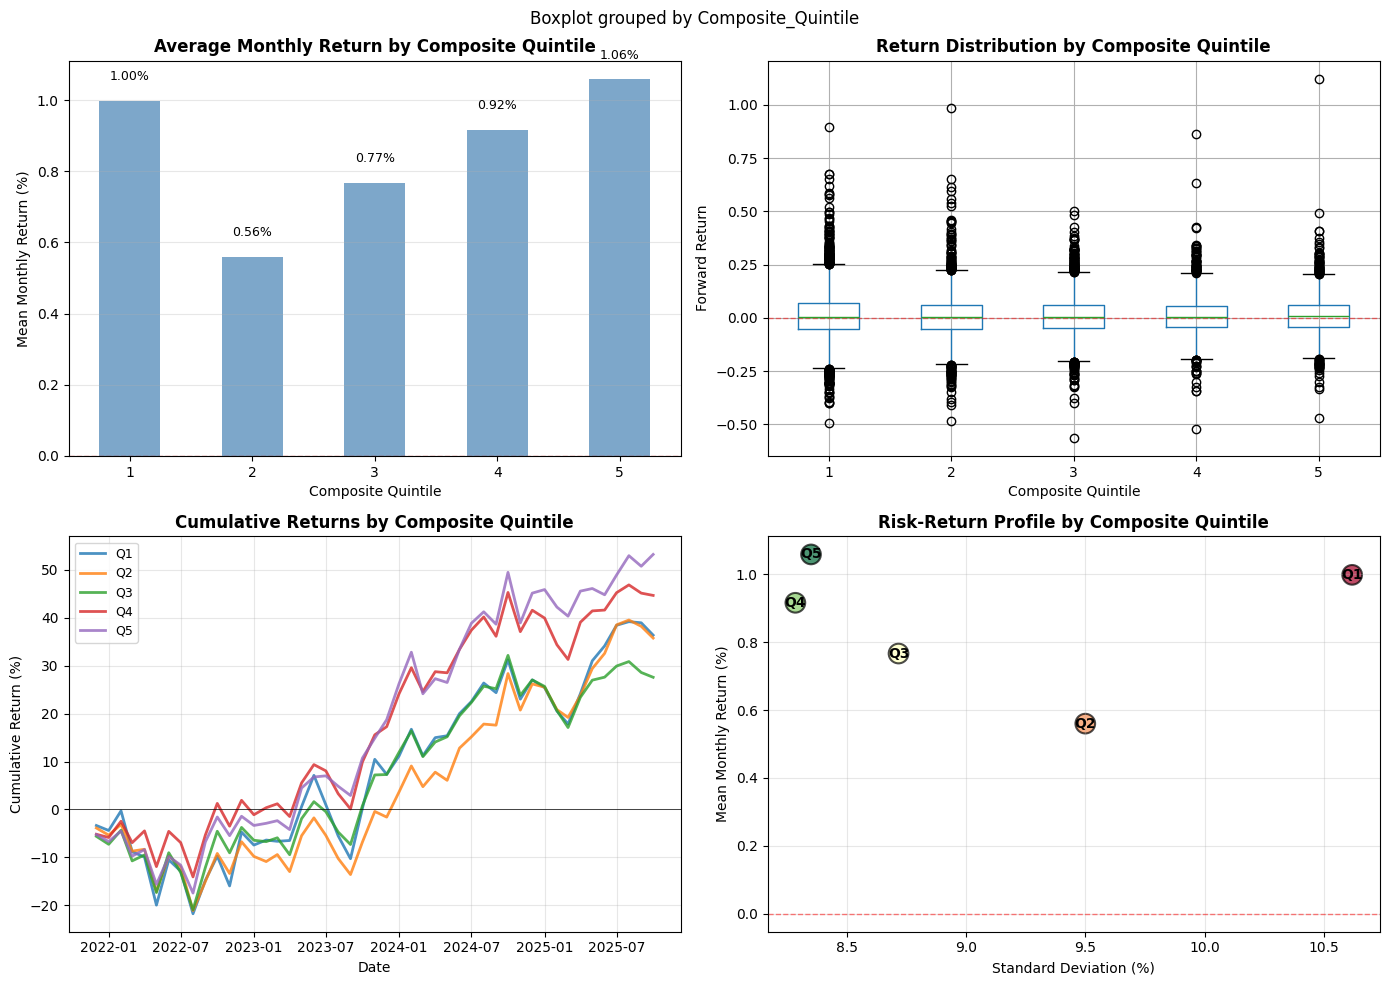


VISUALIZATION COMPLETE


In [17]:
import matplotlib.pyplot as plt

# Create visualization of returns by composite quintile
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Bar chart of mean returns by quintile
ax1 = axes[0, 0]
composite_stats['Mean_Monthly_Return'].plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_title('Average Monthly Return by Composite Quintile', fontsize=12, fontweight='bold')
ax1.set_xlabel('Composite Quintile', fontsize=10)
ax1.set_ylabel('Mean Monthly Return (%)', fontsize=10)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Add value labels on bars
for i, v in enumerate(composite_stats['Mean_Monthly_Return']):
    ax1.text(i, v + 0.05 if v > 0 else v - 0.05, f'{v:.2f}%', 
             ha='center', va='bottom' if v > 0 else 'top', fontsize=9)

# 2. Box plot of return distribution by quintile
ax2 = axes[0, 1]
composite_df.boxplot(column='Forward_Return', by='Composite_Quintile', ax=ax2)
ax2.set_title('Return Distribution by Composite Quintile', fontsize=12, fontweight='bold')
ax2.set_xlabel('Composite Quintile', fontsize=10)
ax2.set_ylabel('Forward Return', fontsize=10)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.sca(ax2)
plt.xticks(rotation=0)

# 3. Cumulative returns over time
ax3 = axes[1, 0]
for q in range(1, 6):
    if q in composite_df['Composite_Quintile'].values:
        quintile_data = composite_df[composite_df['Composite_Quintile'] == q].copy()
        monthly_returns = quintile_data.groupby('Date')['Forward_Return'].mean()
        cumulative_returns = (1 + monthly_returns).cumprod() - 1
        ax3.plot(cumulative_returns.index, cumulative_returns.values * 100, 
                label=f'Q{q}', linewidth=2, alpha=0.8)

ax3.set_title('Cumulative Returns by Composite Quintile', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date', fontsize=10)
ax3.set_ylabel('Cumulative Return (%)', fontsize=10)
ax3.legend(loc='best', fontsize=9)
ax3.grid(alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 4. Risk vs Return scatter
ax4 = axes[1, 1]
scatter = ax4.scatter(composite_stats['Std_Dev'], 
                     composite_stats['Mean_Monthly_Return'],
                     s=200, c=range(1, len(composite_stats)+1), 
                     cmap='RdYlGn', alpha=0.7, edgecolors='black', linewidth=1.5)

# Add labels for each quintile
for idx, row in composite_stats.iterrows():
    ax4.annotate(f'Q{int(idx)}', 
                (row['Std_Dev'], row['Mean_Monthly_Return']),
                ha='center', va='center', fontsize=10, fontweight='bold')

ax4.set_title('Risk-Return Profile by Composite Quintile', fontsize=12, fontweight='bold')
ax4.set_xlabel('Standard Deviation (%)', fontsize=10)
ax4.set_ylabel('Mean Monthly Return (%)', fontsize=10)
ax4.grid(alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("VISUALIZATION COMPLETE")
print("="*70)


In [18]:
merged_df.to_csv('spx_signal.csv', index=False)